In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
plt.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures'

behavior = None
experiment_name = 'B01' 
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
    
for isub in range(exp.nsub):
    # Load subject's behavior data
    if behavior is None:
        behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','Block Feature','ACC','RT']]
    else:
        temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','Block Feature','ACC','RT']]
        behavior = behavior.append(temp)

behavior['BlockFeature'] = behavior['Block Feature'].map({0:'Color',1:'Orientation'})
behavior.tail()

,Subject,SetSize,Block Feature,ACC,RT,BlockFeature
850,17,1,1,1,582.629951,Orientation
851,17,1,1,1,592.172719,Orientation
852,17,3,1,1,761.773224,Orientation
853,17,1,1,1,402.485419,Orientation
854,17,1,1,1,420.117528,Orientation


In [3]:
total_means = behavior.groupby(['SetSize','BlockFeature'])['ACC'].agg(['mean','std'])
subject_means = behavior.groupby(['SetSize','BlockFeature','Subject'])['ACC'].mean().reset_index()
total_means

mean       std
SetSize BlockFeature                    
1       Color         0.982436  0.131381
        Orientation   0.963636  0.187220
3       Color         0.921000  0.269778
        Orientation   0.825581  0.379523

In [4]:
def get_error(setsize, block_feature):
    query = (f"(SetSize == {setsize}) & (BlockFeature == '{block_feature}')")
    return subject_means.query(query).groupby('Subject').mean().reset_index()['ACC']

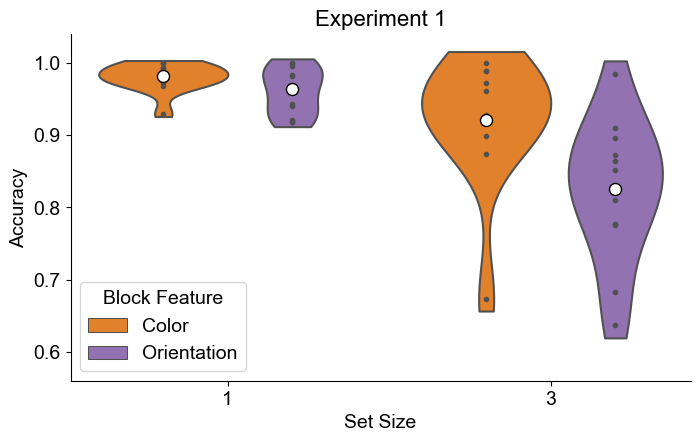

In [5]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {'Color': 'tab:orange', 'Orientation': 'tab:purple'}

# experiment 1
sns.violinplot(
    ax = ax,
    x = 'SetSize',
    y = 'ACC',
    hue = 'BlockFeature',
    data = subject_means,
    dodge=True,
    inner='points',
    palette=my_pal,
    cut=.3
)

# plot means
total_means_vals = total_means['mean'].values
ax.scatter(
    x = [-.2,.2,.8,1.2],
    y = [total_means_vals[0],total_means_vals[1],total_means_vals[2],total_means_vals[3]],
    c = 'white', edgecolors='k',s=75)

# asethetics
plt.legend(loc='lower left',fontsize=14,title_fontsize=14)
leg = ax.get_legend()
leg.set_title(title='Block Feature')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Set Size',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_title('Experiment 1',fontsize=16)
plt.ylim([.56,1.04])
plt.savefig(f'{fig_dir}/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig(f'{fig_dir}/cd_accuracy.svg',bbox_inches='tight')

plt.show()

# Accuracy ANOVA within each experiment

In [6]:
subject_means = subject_means.rename({'BlockFeature':'Feature'},axis=1)

In [7]:
subject_means.head()

,SetSize,Feature,Subject,ACC
0,1,Color,5,0.974910
1,1,Color,7,0.967871
2,1,Color,8,1.000000
3,1,Color,11,0.992857
4,1,Color,12,0.978723


In [8]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(subject_means, 'ACC', 'Subject', within=['Feature','SetSize'],aggregate_func='mean')
res = aovrm.fit()
print(res)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Feature         32.7424 1.0000 11.0000 0.0001
SetSize         20.5953 1.0000 11.0000 0.0008
Feature:SetSize 16.7286 1.0000 11.0000 0.0018



In [9]:
subject_means.groupby(['Feature'])['ACC'].mean()

Feature
Color          0.950757
Orientation    0.892531
Name: ACC, dtype: float64

In [10]:
subject_means.groupby(['Feature'])['ACC'].std()

Feature
Color          0.068981
Orientation    0.099339
Name: ACC, dtype: float64

## test of the interaction

In [11]:
ss3_color = subject_means.query('SetSize==3 & Feature=="Color"')
ss3_ori = subject_means.query('SetSize==3 & Feature=="Orientation"')
ss1_color = subject_means.query('SetSize==1 & Feature=="Color"')
ss1_ori = subject_means.query('SetSize==1 & Feature=="Orientation"')

# assert that the subjects are in the same order
assert all(ss3_color.Subject.values == ss3_ori.Subject.values)
assert all(ss3_ori.Subject.values == ss1_color.Subject.values)
assert all(ss1_color.Subject.values == ss1_ori.Subject.values)

# is the feature difference larger in set size 3 than in set size 1?
diffs = (ss3_color.ACC.values - ss3_ori.ACC.values) - (ss1_color.ACC.values - ss1_ori.ACC.values)

In [12]:
from pingouin import ttest
ttest(diffs, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.090059,11,two-sided,0.001789,"[0.04, 0.12]",1.180698,24.535,0.960184
